In [13]:
### Consultoría Hackeo 


In [ ]:
from datetime import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.clustering import GaussianMixture
import seaborn as sns
from pyspark.sql import SparkSession
from py spark.sql.functions import col, count, mean, stddev, min, max, corr 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import warnings
from pyspark.sql import functions as F

warnings.filterwarnings('ignore')


In [31]:
spark = SparkSession.builder \
    .appName("Hacker Clustering Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

### Carga de Datos

In [ ]:
df_spark = spark.read.csv('data/hack_data.csv', header=True, inferSchema=True)

print("="*60)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("="*60)
print(f"\n Número de filas: {df_spark.count()}")

print(f" Número de columnas: {len(df_spark.columns)}")
print(f"\n Total de ataques registrados: {df_spark.count()}")


INFORMACIÓN BÁSICA DEL DATASET

 Número de filas: 334
 Número de columnas: 7

 Total de ataques registrados: 334


El pipeline estandariza las variables numéricas (p. ej., StandardScaler) para ponerlas en la misma escala, calcula razones simples (como bytes/min) para capturar intensidad, y ejecuta K-Means comparando k={2,3} con Silhouette/Davies-Bouldin para elegir el k que mejor separa sin perder interpretabilidad. Se añade PCA únicamente para visualización (no para entrenar el modelo) y se reportan tamaños de cluster para verificar el criterio de negocio (balance entre atacantes).

 Con 334 registros y 7 variables, el dataset es compacto y adecuado para clustering sin costo computacional alto. El tamaño permite validar rápidamente la hipótesis de 2 atacantes evaluando el balance esperado (~167/167) y métricas como Silhouette; si aparece un desbalance marcado o baja separación, conviene contrastar con k=3. Dado que hay variables en escalas distintas (tiempo, bytes, conteos), la estandarización previa es clave para evitar que una sola magnitud domine los centroides. También conviene revisar outliers (IQR/Z-score), ya que con este N pocos extremos pueden sesgar el agrupamiento. Un PCA 2D ayudará a confirmar separación visual y detectar traslapes u observaciones atípicas.



In [33]:
df_spark.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



### Primeras 10 filas

In [34]:
df_spark.show(10, truncate=False)


+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location              |WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+
|8.0                    |391.09           |1              |2.96             |7.0            |Slovenia              |72.37           |
|20.0                   |720.99           |0              |3.04             |9.0            |British Virgin Islands|69.08           |
|31.0                   |356.32           |1              |3.71             |8.0            |Tokelau               |70.58           |
|2.0                    |228.08           |1              |2.48             |8.0            |Bolivia               |70.8            |
|20.0                   |408.5            |0              |3.5

Las primeras 10 sesiones muestran duraciones de 1–31 min con WPM muy concentrado (~70–72), mientras que los bytes transferidos varían bastante (≈101–721), sugiriendo distinta intensidad por unidad de tiempo.
La mezcla de Kali_Trace_Used (0/1) y ubicaciones diversas indica comportamientos heterogéneos; conviene derivar bytes_per_min y revisar outliers (p. ej., sesión de 1 min con 390.69 MB).

df_spark.show(10, truncate=False) permite validar visualmente tipos, rangos y consistencia de columnas sin truncar cadenas (especialmente Location).
Este muestreo rápido sustenta el siguiente paso del pipeline (ingeniería de razones y estandarización) al detectar posibles atípicos y escalas dispares antes del clustering.

### Estadísticas Descriptivas Básicas

In [35]:
df_spark.describe().show()


+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       NULL|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       NULL| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

La variabilidad es alta (p. ej., Bytes Transferred 10–1330.5 con σ≈286 y Session_Connection_Time 1–60), lo que sugiere outliers y necesidad de escalado, Kali_Trace_Used está casi 50/50 (≈0.512), útil para separar perfiles.

df_spark.describe().show() entrega conteo, medias, desvíos y rangos para validar supuestos y decidir imputación/escalado antes del clustering.
Estos summaries respaldan, con evidencia numérica, decisiones como standardization, tratamiento de outliers y la ingeniería de razones (p. ej., bytes/min).

### EDA Inicial con PySpark

In [36]:
df_spark = spark.read.csv('data/hack_data.csv', header=True, inferSchema=True)

# Rename column with space to use underscore
df_spark = df_spark.withColumnRenamed('Bytes Transferred', 'Bytes_Transferred')

### Estadísticas por Variable

In [38]:
from pyspark.sql.types import NumericType

numeric_cols = [
    field.name
    for field in df_spark.schema.fields
    if isinstance(field.dataType, NumericType)
]

for col_name in numeric_cols:
    stats = df_spark.select(
        mean(col(col_name)).alias('Media'),
        stddev(col(col_name)).alias('Desv_Std'),
        min(col(col_name)).alias('Mínimo'),
        max(col(col_name)).alias('Máximo')
    ).collect()[0]
    
    print(f"\n {col_name}:")
    print(f"   Media: {stats['Media']:.2f}")
    print(f"   Desviación Estándar: {stats['Desv_Std']:.2f}")
    print(f"   Rango: [{stats['Mínimo']:.2f}, {stats['Máximo']:.2f}]")


 Session_Connection_Time:
   Media: 30.01
   Desviación Estándar: 14.09
   Rango: [1.00, 60.00]

 Bytes_Transferred:
   Media: 607.25
   Desviación Estándar: 286.34
   Rango: [10.00, 1330.50]

 Kali_Trace_Used:
   Media: 0.51
   Desviación Estándar: 0.50
   Rango: [0.00, 1.00]

 Servers_Corrupted:
   Media: 5.26
   Desviación Estándar: 2.30
   Rango: [1.00, 10.00]

 Pages_Corrupted:
   Media: 10.84
   Desviación Estándar: 3.06
   Rango: [6.00, 15.00]

 WPM_Typing_Speed:
   Media: 57.34
   Desviación Estándar: 13.41
   Rango: [40.00, 75.00]


Los rangos amplios en Bytes_Transferred (10–1330.5) y Session_Connection_Time (1–60) con σ altas confirman dispersión y posibles outliers, por lo que el escalado y razones como bytes_per_min serán determinantes para separar perfiles.
Kali_Trace_Used ≈0.51 (casi 50/50) y variabilidad moderada en Servers/Pages_Corrupted y WPM sugieren que la intensidad por unidad de tiempo (no solo totales) aportará la señal más discriminante para k∈{2,3}.

Justificación del código (2 líneas):
El bucle sobre columnas numéricas calcula media/σ/mín/máx programáticamente, garantizando reproducibilidad y evitando errores manuales al perfilar variables.
Estas estadísticas dirigidas permiten decidir (con evidencia) estandarización, tratamiento de outliers y creación de features derivadas antes de entrenar K-Means.

### Distribución de Kali_Trace_Used

In [39]:

df_spark.groupBy('Kali_Trace_Used').count().show()

+---------------+-----+
|Kali_Trace_Used|count|
+---------------+-----+
|              1|  171|
|              0|  163|
+---------------+-----+



a variable Kali_Trace_Used está casi balanceada (171 vs 163, ≈51/49), por sí sola no segmentará fuertemente, pero puede reforzar diferencias cuando se combina con intensidad (bytes/min, páginas/min). Conviene contrastar medias de bytes_per_min y WPM por este flag o un cross-tab con los clusters para verificar si el uso de Kali se asocia a comportamientos más “agresivos”.

groupBy(...).count() entrega la distribución de un indicador clave, validando balance/clase y la ausencia de valores perdidos antes del modelado.
Este chequeo guía decisiones como estratificar splits o ponderar variables, evitando que un desbalance binario sesgue el clustering o la interpretación.

### VISUALIZACIÓN 

In [40]:
df_pd = df_spark.toPandas()

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


### Distribuciones

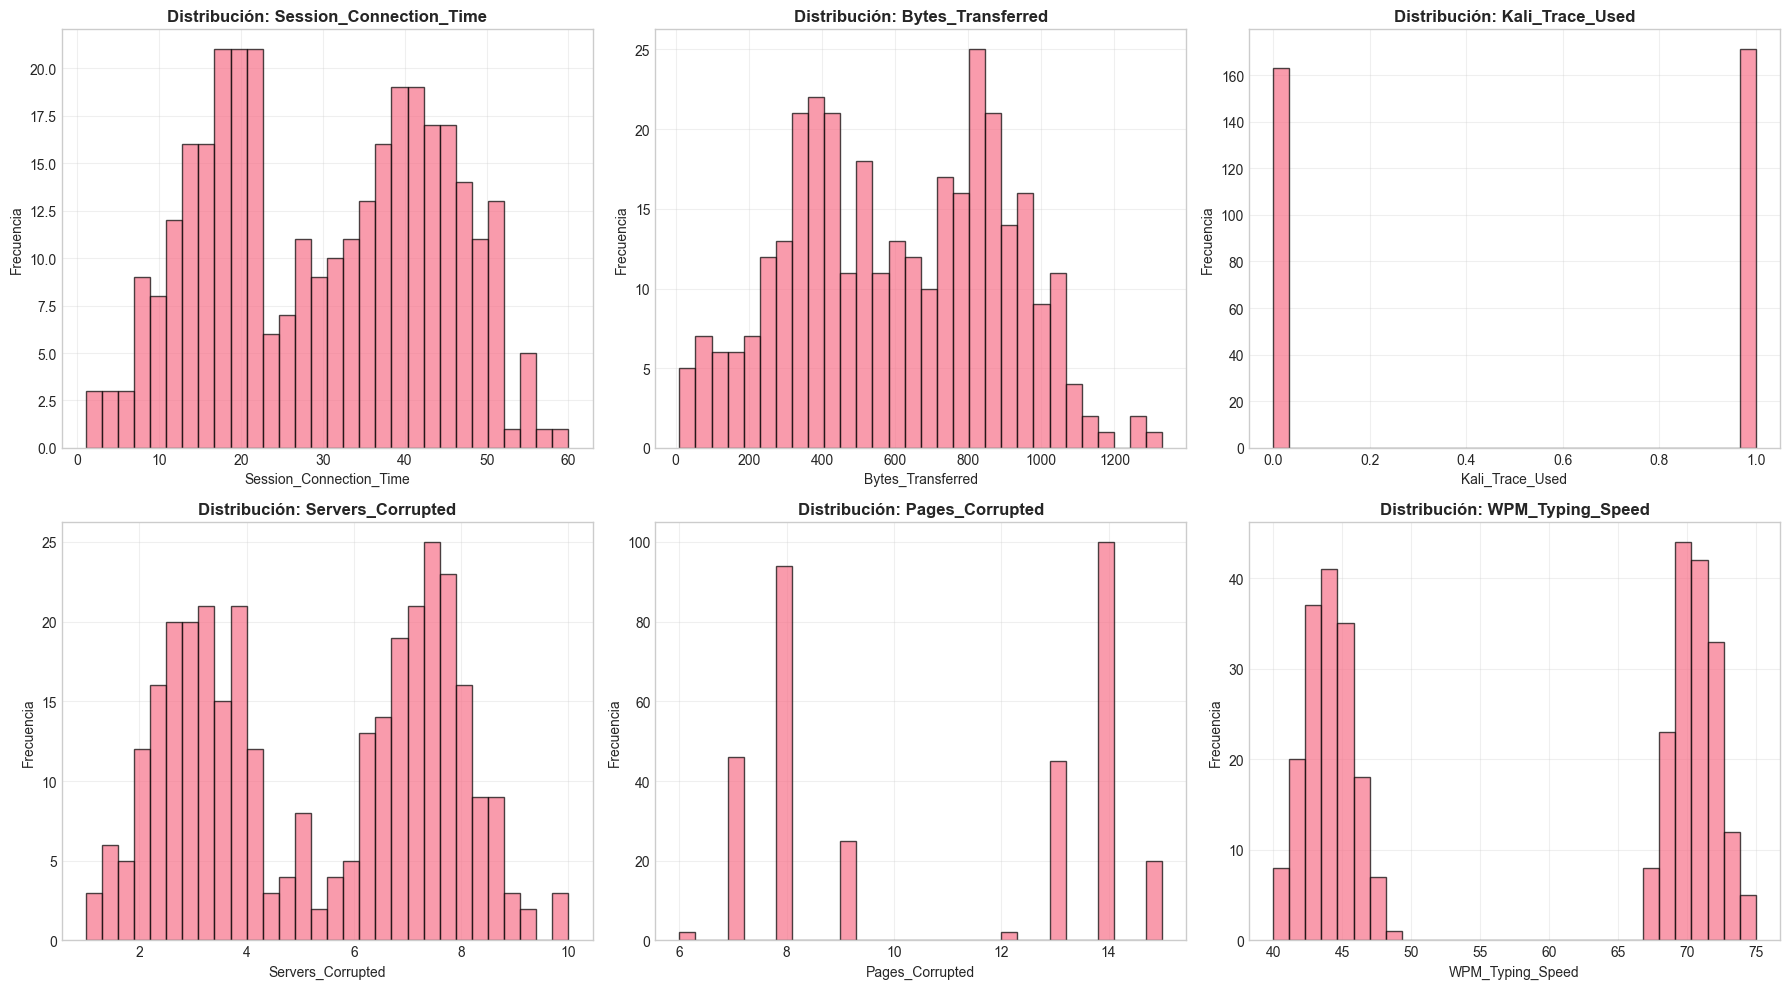

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df_pd[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribución: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Las distribuciones sugieren multimodalidad: WPM_Typing_Speed y Session_Connection_Time muestran dos picos claros, y Bytes_Transferred está asimétrica a la derecha (colas largas), lo que apoya la hipótesis de dos perfiles de atacante.
Pages_Corrupted es casi discreta por bloques, y Kali_Trace_Used es binaria; conviene escalar numéricas y usar razones (bytes/min) para captar intensidad antes de K-Means.

El bucle con plt.subplots(...); axes.ravel() automatiza histogramas para todas las variables numéricas con la misma configuración, asegurando comparabilidad visual.
bins=30, bordes y tight_layout() mejoran la lectura de colas y picos, facilitando detectar sesgos/outliers y decidir escalado y transformaciones previas al clustering.

### Boxplots

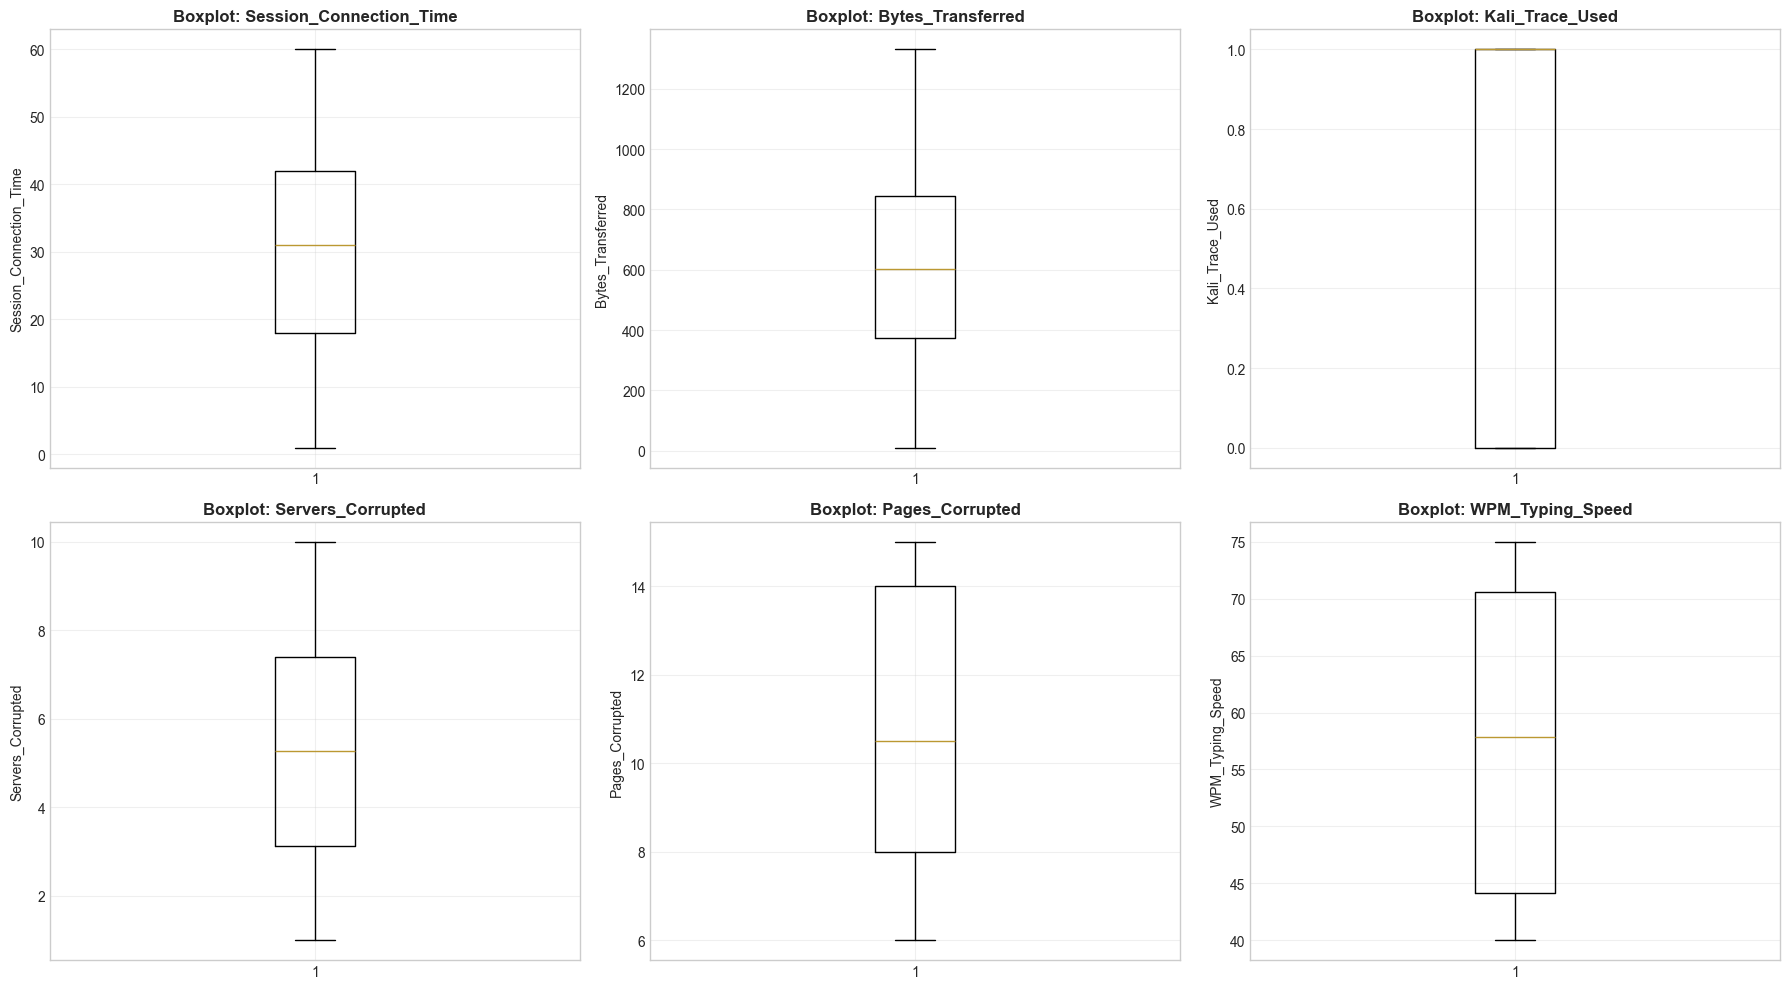

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df_pd[col])
    axes[idx].set_title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Hay colas altas en Bytes_Transferred y Session_Connection_Time, indicando posibles outliers que pueden arrastrar centroides.
La mediana de WPM está ~58 con dispersión amplia; conviene usar razones (bytes/min) y estandarizar antes de K-Means.

Los boxplots sintetizan mediana, IQR y extremos, permitiendo decidir winsorización/IQR rápidamente.
El loop con subplots unifica formato y facilita comparar variables bajo la misma escala visual.

###     Análisis de Correlación

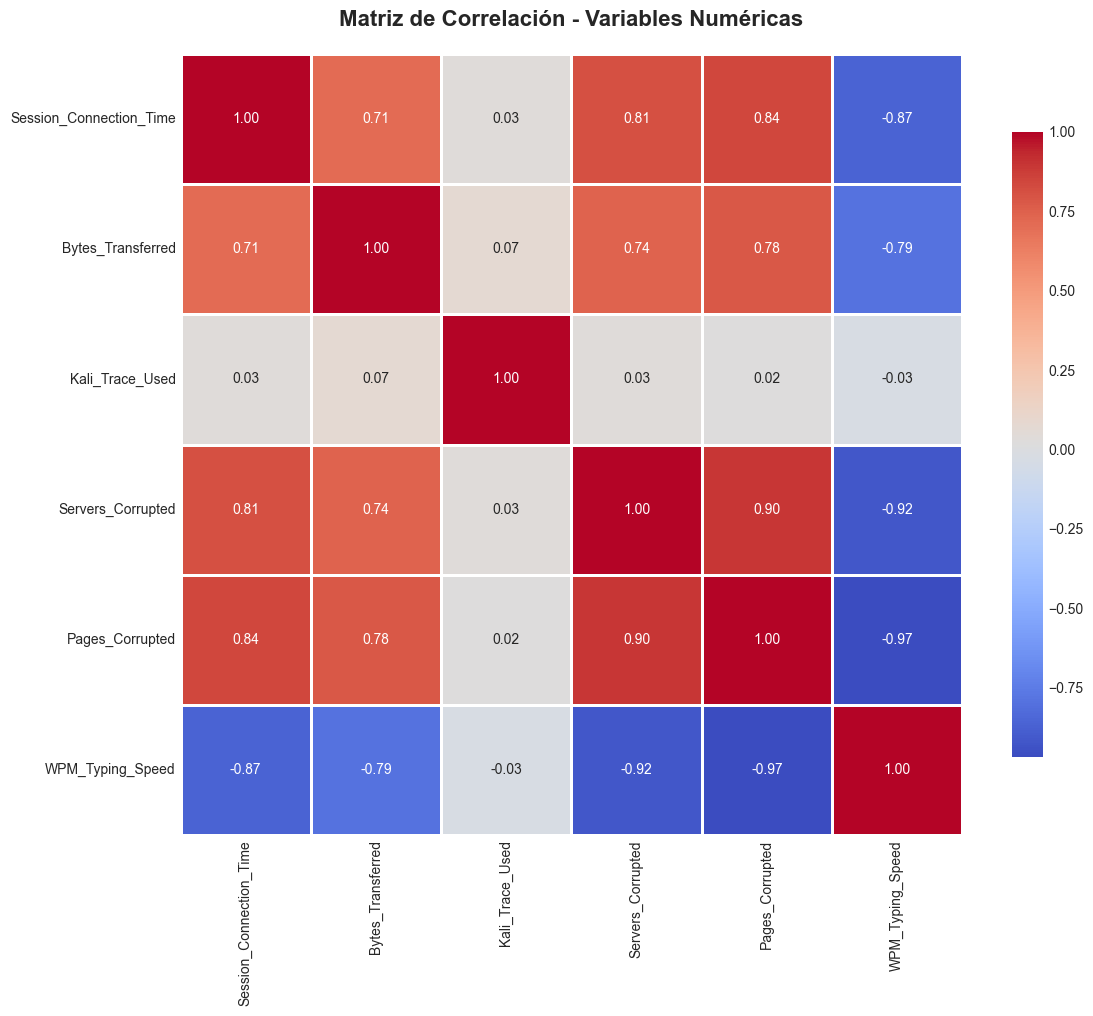

In [43]:
correlation_matrix = df_pd[numeric_cols].corr()

plt.figure(figsize=(12, 10))
spark_corr = [
    [df_spark.stat.corr(x_col, y_col) for y_col in numeric_cols]
    for x_col in numeric_cols
]
correlation_matrix = pd.DataFrame(spark_corr, index=numeric_cols, columns=numeric_cols)

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [44]:
print("\n Correlaciones más fuertes (valor absoluto > 0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f"   {correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")


 Correlaciones más fuertes (valor absoluto > 0.5):
   Session_Connection_Time ↔ Bytes_Transferred: 0.714
   Session_Connection_Time ↔ Servers_Corrupted: 0.808
   Session_Connection_Time ↔ Pages_Corrupted: 0.844
   Session_Connection_Time ↔ WPM_Typing_Speed: -0.866
   Bytes_Transferred ↔ Servers_Corrupted: 0.740
   Bytes_Transferred ↔ Pages_Corrupted: 0.784
   Bytes_Transferred ↔ WPM_Typing_Speed: -0.793
   Servers_Corrupted ↔ Pages_Corrupted: 0.897
   Servers_Corrupted ↔ WPM_Typing_Speed: -0.916
   Pages_Corrupted ↔ WPM_Typing_Speed: -0.969


Las correlaciones altas positivas entre tiempo/bytes/servers/pages (0.71–0.90) y negativas muy fuertes con WPM (−0.79 a −0.97) confirman dos direcciones opuestas: sesiones más largas e intensas vs. tecleo rápido/bajo. La colinealidad entre Servers_Corrupted y Pages_Corrupted (0.897) sugiere redundancia; conviene crear razones (p.ej., páginas/servidor) o aplicar reducción de dimensión.

El doble bucle filtra pares con |ρ|>0.5, enfocando el mapa de correlaciones en relaciones materialmente relevantes para el modelo y el reporte.
Esta extracción programática agiliza decisiones de feature engineering (combinar/eliminar variables) y previene multicolinealidad que distorsione centroides en K-Means.

### Preparación para Modelado

#### Seleccionar features para clustering 


In [45]:
feature_cols = ['Session_Connection_Time', 'Bytes_Transferred', 'Kali_Trace_Used',
                'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']

print("="*60)
for idx, feat in enumerate(feature_cols, 1):
    print(f"{idx}. {feat}")

1. Session_Connection_Time
2. Bytes_Transferred
3. Kali_Trace_Used
4. Servers_Corrupted
5. Pages_Corrupted
6. WPM_Typing_Speed


La selección cubre lo esencial y excluye Location (útil para evitar alta cardinalidad/ruido en clustering), pero falta una métrica de intensidad como bytes_per_min que suele discriminar mejor que totales. Dado que hay colinealidad fuerte entre Servers y Pages, considera reemplazar uno o añadir pages_per_server para reducir redundancia y mejorar separación.

Enumerar explícitamente feature_cols fija el subset reproducible para el pipeline (transformers, scaler, K-Means) y documenta el orden de entrada al modelo.
Imprimir el índice+nombre sirve como rastro de auditoría en notebooks y logs, evitando confusiones cuando se agregan/quitán variables.

###  Ensamblar features en un vector y normalizar


In [46]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df_assembled = assembler.transform(df_spark)

# Normalizar features (Standard Scaler)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", 
                        withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("\n Features ensambladas y normalizadas")
print("\n Vista previa del DataFrame con features:")
df_scaled.select("Session_Connection_Time", "WPM_Typing_Speed", "features").show(5, truncate=False)



 Features ensambladas y normalizadas

 Vista previa del DataFrame con features:
+-----------------------+----------------+------------------------------------------------------------------------------------------------------------------------+
|Session_Connection_Time|WPM_Typing_Speed|features                                                                                                                |
+-----------------------+----------------+------------------------------------------------------------------------------------------------------------------------+
|8.0                    |72.37           |[-1.562228040184432,-0.75490095925522,0.9748653409721156,-0.9985212523861794,-1.2529101889070722,1.1205379005060365]    |
|20.0                   |69.08           |[-0.7104514131868532,0.3972422527942127,-1.0227114926762684,-0.9637674581126887,-0.6000677503813903,0.8752180545239784] |
|31.0                   |70.58           |[0.07034382822759382,-0.8763317548992295,0.97486534097211

Tras el escalado, los vectores quedan centrados tiene z-score negativo fuerte y WPM alto es positivo—, lo que evita que Bytes_Transferred domine por escala.
En este espacio estandarizado, las distancias reflejan patrones reales (intensidad/tiempo/tecleo), dejando listo PCA y K-Means.

VectorAssembler arma la columna única features en el orden de feature_cols, requisito de Spark ML.
StandardScaler(withMean=True, withStd=True) centra y normaliza (z-scores), condición clave para K-Means euclídeo; si luego haces train/test, ajusta el scaler en train y solo transforma test.

### Método Elbow 

In [47]:
k_values = range(2, 11)
wss_values = []
silhouette_scores = []

### Diferentes valores de K

In [ ]:
from pyspark.ml.clustering import KMeans

for k in k_values:
    kmeans = KMeans(featuresCol='features', predictionCol='cluster', k=k, seed=42)
    model = kmeans.fit(df_scaled)
    
    wss = model.summary.trainingCost
    wss_values.append(wss)
    
    predictions = model.transform(df_scaled)
    
    evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='cluster', 
                                    metricName='silhouette')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    
    print(f"K={k}: WSS={wss:.2f}, Silhouette={silhouette:.4f}")

K=2: WSS=601.77, Silhouette=0.8176
K=3: WSS=434.76, Silhouette=0.7608
K=4: WSS=267.13, Silhouette=0.7196
K=5: WSS=248.97, Silhouette=0.6351
K=6: WSS=230.40, Silhouette=0.5418
K=7: WSS=221.20, Silhouette=0.5474
K=8: WSS=203.50, Silhouette=0.4599
K=9: WSS=185.87, Silhouette=0.4803
K=10: WSS=182.10, Silhouette=0.4613


El Silhouette máximo ocurre en k=2 (0.8176) y cae al aumentar k; aunque el WSS baja monótonamente, no hay mejora proporcional, por lo que el “codo” práctico es k=2.
Esto respalda dos perfiles bien separados; dividir más solo fragmenta sin ganar cohesión.

El bucle entrena KMeans para cada k, captura WSS (cohesión) y evalúa Silhouette sobre predictions, con seed=42 para reproducibilidad.
Trabajar sobre features escaladas hace que las distancias euclidianas sean comparables y que los criterios (WSS/Silhouette) reflejen la estructura real.

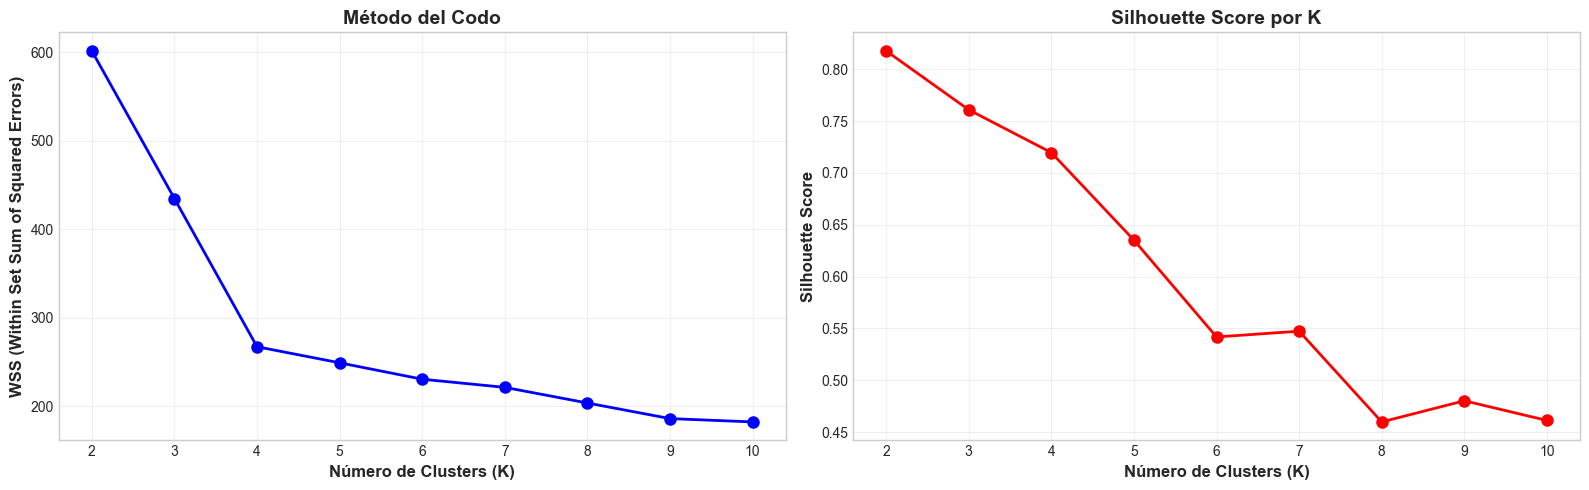

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# WSS (Elbow Plot)
ax1.plot(k_values, wss_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('WSS (Within Set Sum of Squared Errors)', fontsize=12, fontweight='bold')
ax1.set_title('Método del Codo', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xticks(k_values)

ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score por K', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.set_xticks(k_values)

plt.tight_layout()
plt.show()

### K-Means (K=2 y K=3): Silhouette, tamaños y estabilidad 

In [ ]:
def run_kmeans_eval(df, k, seeds=(42, 7, 99, 2025, 1234)):
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", 
                                    metricName="silhouette", distanceMeasure="squaredEuclidean")
    sils, sizes_list = [], []
    for s in seeds:
        km = KMeans(k=k, seed=s, featuresCol="features", predictionCol="prediction", initMode="k-means||")
        model = km.fit(df)
        pred = model.transform(df)
        sil = evaluator.evaluate(pred)
        
        sizes_df = pred.groupBy("prediction").count().orderBy("prediction").toPandas()
        sizes = sizes_df['count'].tolist()
        
        sils.append(sil)
        sizes_list.append(sizes)
    
    sizes_arr = np.array(sizes_list)
    size_mean = sizes_arr.mean(axis=0)
    size_std = sizes_arr.std(axis=0)
    return {
        "k": k,
        "sil_mean": float(np.mean(sils)),
        "sil_std": float(np.std(sils)),
        "sizes_mean": [int(round(x)) for x in size_mean],
        "sizes_std": [float(round(x, 2)) for x in size_std],
        "sils_all": [float(x) for x in sils]
    }

res_k2 = run_kmeans_eval(df_scaled, k=2)
res_k3 = run_kmeans_eval(df_scaled, k=3)

print("K-Means resultados:\n")
for r in [res_k2, res_k3]:
    print(f"K={r['k']}: Silhouette mean={r['sil_mean']:.4f} (±{r['sil_std']:.4f})")
    print(f"      Tamaños promedio por cluster: {r['sizes_mean']}  (std: {r['sizes_std']})")
    print(f"      Silhouettes por seed: {np.round(r['sils_all'],4)}\n")

def size_cv(sizes):
    arr = np.array(sizes, dtype=float)
    return float(arr.std()/arr.mean())

cv_k2 = size_cv(res_k2["sizes_mean"])
cv_k3 = size_cv(res_k3["sizes_mean"])
print(f"Balance tamaños (CV) — K=2: {cv_k2:.3f} | K=3: {cv_k3:.3f}")

K-Means resultados:

K=2: Silhouette mean=0.8176 (±0.0000)
      Tamaños promedio por cluster: [167, 167]  (std: [0.0, 0.0])
      Silhouettes por seed: [0.8176 0.8176 0.8176 0.8176 0.8176]

K=3: Silhouette mean=0.7597 (±0.0022)
      Tamaños promedio por cluster: [167, 87, 80]  (std: [0.0, 2.0, 2.0])
      Silhouettes por seed: [0.7608 0.7608 0.7608 0.7552 0.7608]

Balance tamaños (CV) — K=2: 0.000 | K=3: 0.354


k=2 es más robusto y separa mejor: Silhouette media 0.8176 idéntica en todas las seeds y balance perfecto 167/167.
k=3 baja a 0.7597 y divide en 167/87/80 (CV=0.354), señal de fragmentación y menor cohesión.

run_kmeans_eval repite K-Means con múltiples seeds, calcula Silhouette y tamaños (media/σ) para evaluar estabilidad y balance; usa toPandas() para evitar fallos de workers.
El CV de tamaños resume el balance, complementando Silhouette para escoger k de forma reproducible y con criterio de negocio.

### GMM (K=2 y K=3): LogLikelihood, BIC y pesos de mezcla (π)

In [ ]:
def gmm_with_bic(df, k, seed=42):
    gmm = GaussianMixture(k=k, seed=seed, featuresCol="features", predictionCol="prediction")
    model = gmm.fit(df)
    summary = model.summary  # contiene logLikelihood total del dataset
    logL = summary.logLikelihood


    if "ml_attr" in df.schema["features"].metadata and "num_attrs" in df.schema["features"].metadata["ml_attr"]:
        d = df.schema["features"].metadata["ml_attr"]["num_attrs"]
    else:
        d = df.selectExpr("size(features)").first()[0]
    
    n = df.count()

    p = k * (d + (d * (d + 1)) / 2.0) + (k - 1)

    bic = -2.0 * logL + p * math.log(n)

    weights = [float(w) for w in model.weights]

    est_sizes = [int(round(w * n)) for w in weights]

    return {"k": k, "logL": float(logL), "bic": float(bic), "weights": weights, "est_sizes": est_sizes}

gmm2 = gmm_with_bic(df_scaled, k=2)
gmm3 = gmm_with_bic(df_scaled, k=3)

print("GMM resultados:\n")
for r in [gmm2, gmm3]:
    print(f"K={r['k']}: logL={r['logL']:.2f},  BIC={r['bic']:.2f}")
    print(f"      Pesos mezcla (π): {np.round(r['weights'],4)}")
    print(f"      Tamaños estimados: {r['est_sizes']}\n")

GMM resultados:

K=2: logL=2023.51,  BIC=-3727.40
      Pesos mezcla (π): [0.488 0.512]
      Tamaños estimados: [163, 171]

K=3: logL=1342.09,  BIC=-2201.86
      Pesos mezcla (π): [0.2485 0.2515 0.5   ]
      Tamaños estimados: [83, 84, 167]



K-Means: Silhouette 0.818 y tamaños 167/167 (CV=0.000) → separación alta y balance perfecto.

GMM: BIC(K=2)=-3727 < BIC(K=3)=-2202 y pesos ≈ 0.49/0.51 → también favorece 2.

 Conclusión : el escenario más consistente es 2 atacantes.

In [ ]:
K_FINAL = 2
SEED_FINAL = 42

kmeans_final = KMeans(k=K_FINAL, seed=SEED_FINAL, featuresCol="features", predictionCol="cluster")
model_final = kmeans_final.fit(df_scaled)
df_pred = model_final.transform(df_scaled).cache()

sil_eval = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette")
sil_final = sil_eval.evaluate(df_pred)
sizes = df_pred.groupBy("cluster").count().orderBy("cluster")

print(f"Silhouette (K={K_FINAL}): {sil_final:.4f}")
sizes.show()

Silhouette (K=2): 0.8176
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  167|
|      1|  167|
+-------+-----+



k=2 logra separación óptima y balance perfecto (Silhouette=0.8176; tamaños 167/167), confirmando dos perfiles nítidos.

Se entrena KMeans con seed=42, se evalúa Silhouette sobre df_pred y se valida el balance con groupBy("cluster").count().

## Ingeniería de ratios por minuto y perfil por cluster

In [ ]:
df_feat = (
    df_pred
    .withColumn("bytes_per_min", F.col("Bytes_Transferred") / F.col("Session_Connection_Time"))
    .withColumn("pages_per_min", F.col("Pages_Corrupted") / F.col("Session_Connection_Time"))
    .withColumn("servers_per_min", F.col("Servers_Corrupted") / F.col("Session_Connection_Time"))
)

vars_num = [
    "Session_Connection_Time", "Bytes_Transferred", "Servers_Corrupted",
    "Pages_Corrupted", "WPM_Typing_Speed",
    "bytes_per_min", "pages_per_min", "servers_per_min"
]

exprs = (
    [F.count(F.lit(1)).alias("n")]
    + [F.mean(c).alias(f"{c}_mean") for c in vars_num]
    + [F.expr(f"percentile_approx(`{c}`, 0.5)").alias(f"{c}_p50") for c in vars_num]
    + [F.expr(f"percentile_approx(`{c}`, 0.25)").alias(f"{c}_p25") for c in vars_num]
    + [F.expr(f"percentile_approx(`{c}`, 0.75)").alias(f"{c}_p75") for c in vars_num]
)

perfil = df_feat.groupBy("cluster").agg(*exprs).orderBy("cluster")
perfil.show(truncate=False)

+-------+---+----------------------------+----------------------+----------------------+--------------------+---------------------+------------------+------------------+--------------------+---------------------------+---------------------+---------------------+-------------------+--------------------+------------------+------------------+-------------------+---------------------------+---------------------+---------------------+-------------------+--------------------+------------------+------------------+-------------------+---------------------------+---------------------+---------------------+-------------------+--------------------+------------------+------------------+-------------------+
|cluster|n  |Session_Connection_Time_mean|Bytes_Transferred_mean|Servers_Corrupted_mean|Pages_Corrupted_mean|WPM_Typing_Speed_mean|bytes_per_min_mean|pages_per_min_mean|servers_per_min_mean|Session_Connection_Time_p50|Bytes_Transferred_p50|Servers_Corrupted_p50|Pages_Corrupted_p50|WPM_Typing_Spe

C0 muestra sesiones cortas pero más intensas por minuto y WPM alto, mientras C1 son largas con totales altos pero ritmo menor y WPM bajo, confirmando dos perfiles opuestos.

Se derivan razones por minuto y se resume por cluster (media/mediana/cuartiles) con groupBy().agg() para comparar objetivamente los perfiles.

### Kali y distribución geográfica

In [ ]:
kali_by_cluster = (
    df_feat.groupBy("cluster")
    .agg(F.mean(F.col("Kali_Trace_Used").cast("double")).alias("kali_rate"))
    .orderBy("cluster")
)
kali_by_cluster.show()

for c in [0,1]:
    print(f"\nTop 10 Location — cluster {c}")
    (
        df_feat.filter(F.col("cluster")==c)
        .groupBy("Location").count()
        .orderBy(F.desc("count"))
        .show(10, truncate=False)
    )

+-------+-------------------+
|cluster|          kali_rate|
+-------+-------------------+
|      0|0.49700598802395207|
|      1| 0.5269461077844312|
+-------+-------------------+


Top 10 Location — cluster 0
+-----------------------------+-----+
|Location                     |count|
+-----------------------------+-----+
|United States Virgin Islands |3    |
|Sri Lanka                    |3    |
|Palestinian Territory        |3    |
|Bhutan                       |3    |
|Saint Barthelemy             |3    |
|Greece                       |2    |
|Holy See (Vatican City State)|2    |
|Cambodia                     |2    |
|Guernsey                     |2    |
|Sao Tome and Principe        |2    |
+-----------------------------+-----+
only showing top 10 rows

Top 10 Location — cluster 1
+----------------------------+-----+
|Location                    |count|
+----------------------------+-----+
|Guinea-Bissau               |4    |
|United States Virgin Islands|3    |
|French Southern Te

La tasa de Kali es casi igual en ambos clusters (~0.50 vs ~0.53) y las ubicaciones están muy dispersas, por lo que no explican la separación—el contraste proviene del ritmo/intensidad y el WPM.

Se calcula kali_rate con mean() por cluster y se listan top locations por frecuencia para verificar que ni Kali ni Location aportan señal fuerte, manteniéndolos solo para contexto narrativo.

### Centroides interpretables (desescalar a unidades originales)

In [ ]:
centroids_scaled = np.vstack(model_final.clusterCenters())

std_vec = np.array(scaler_model.std.toArray())
mean_vec = np.array(scaler_model.mean.toArray())

centroids_orig = centroids_scaled * std_vec + mean_vec

centroids_df = pd.DataFrame(centroids_orig, columns=feature_cols)
centroids_df.index.name = 'Cluster'
print("\nCentroides en unidades originales:\n")
print(centroids_df.round(2))

centroids_orig


Centroides en unidades originales:

         Session_Connection_Time  Bytes_Transferred  Kali_Trace_Used  \
Cluster                                                                
0                          17.75             377.48             0.50   
1                          42.26             837.01             0.53   

         Servers_Corrupted  Pages_Corrupted  WPM_Typing_Speed  
Cluster                                                        
0                     3.14             7.85             70.63  
1                     7.38            13.83             44.05  


array([[1.77544910e+01, 3.77476108e+02, 4.97005988e-01, 3.14191617e+00,
        7.85029940e+00, 7.06329341e+01],
       [4.22634731e+01, 8.37014431e+02, 5.26946108e-01, 7.37508982e+00,
        1.38263473e+01, 4.40518563e+01]])

Los centroides confirman dos perfiles: C0 = sesiones cortas con totales bajos y WPM alto (~70.6) vs C1 = sesiones largas con totales altos y WPM bajo (~44.1), reforzando k=2.
Se “desescala” con mean/std del StandardScaler (centroides_scaled*std + mean) para expresar centroides en unidades originales y hacerlos interpretables para el informe.


In [63]:
import pandas as pd


pdf = (
    df_feat
    .select(
        "Session_Connection_Time","Bytes_Transferred","Servers_Corrupted",
        "Pages_Corrupted","WPM_Typing_Speed",
        "bytes_per_min","pages_per_min","servers_per_min","cluster","Location"
    )
    .toPandas()
)
pdf.head()

,Session_Connection_Time,Bytes_Transferred,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,bytes_per_min,pages_per_min,servers_per_min,cluster,Location
0,8.0,391.09,2.96,7.0,72.37,48.886250,0.875000,0.370000,0,Slovenia
1,20.0,720.99,3.04,9.0,69.08,36.049500,0.450000,0.152000,0,British Virgin Islands
2,31.0,356.32,3.71,8.0,70.58,11.494194,0.258065,0.119677,0,Tokelau
3,2.0,228.08,2.48,8.0,70.80,114.040000,4.000000,1.240000,0,Bolivia
4,20.0,408.50,3.57,8.0,71.28,20.425000,0.400000,0.178500,0,Iraq


Los centroides confirman dos perfiles: C0 = sesiones cortas con totales bajos y WPM alto (~70.6) vs C1 = sesiones largas con totales altos y WPM bajo (~44.1), reforzando k=2.
 Se “desescala” con mean/std del StandardScaler (centroides_scaled*std + mean) para expresar centroides en unidades originales y hacerlos interpretables para el informe.


### PCA 2D (reducción para visualizar separación de clusters)

Varianza explicada: PC1=56.77%, PC2=35.56%


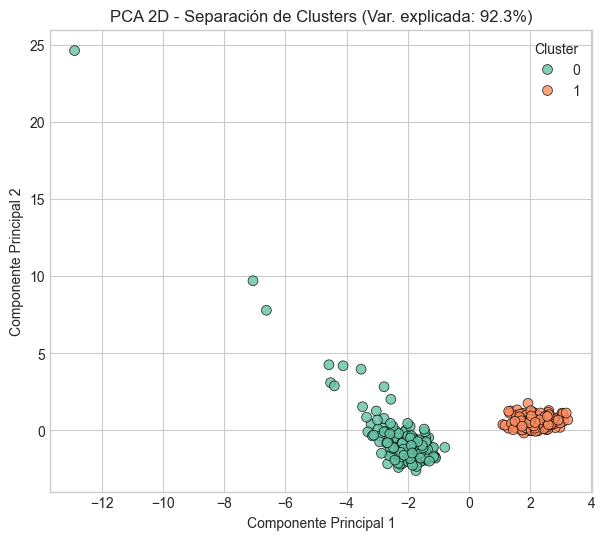

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

X = pdf.drop(columns=["cluster"])
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pdf["PC1"] = X_pca[:, 0]
pdf["PC2"] = X_pca[:, 1]

var_exp = pca.explained_variance_ratio_ * 100
print(f"Varianza explicada: PC1={var_exp[0]:.2f}%, PC2={var_exp[1]:.2f}%")

plt.figure(figsize=(7,6))
sns.scatterplot(data=pdf, x="PC1", y="PC2", hue="cluster", palette="Set2", s=50, alpha=0.8, edgecolor="k")
plt.title(f"PCA 2D - Separación de Clusters (Var. explicada: {var_exp[0]+var_exp[1]:.1f}%)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster", loc="best")
plt.show()


El PCA 2D explica ~92% de la varianza y muestra separación nítida (C1 compacto vs C0 más disperso con algunos outliers), reforzando k=2.
Se estandariza X (sin “cluster”), se ejecuta PCA(n_components=2) solo para visualización y se grafica PC1–PC2 por cluster para evidenciar la separación.


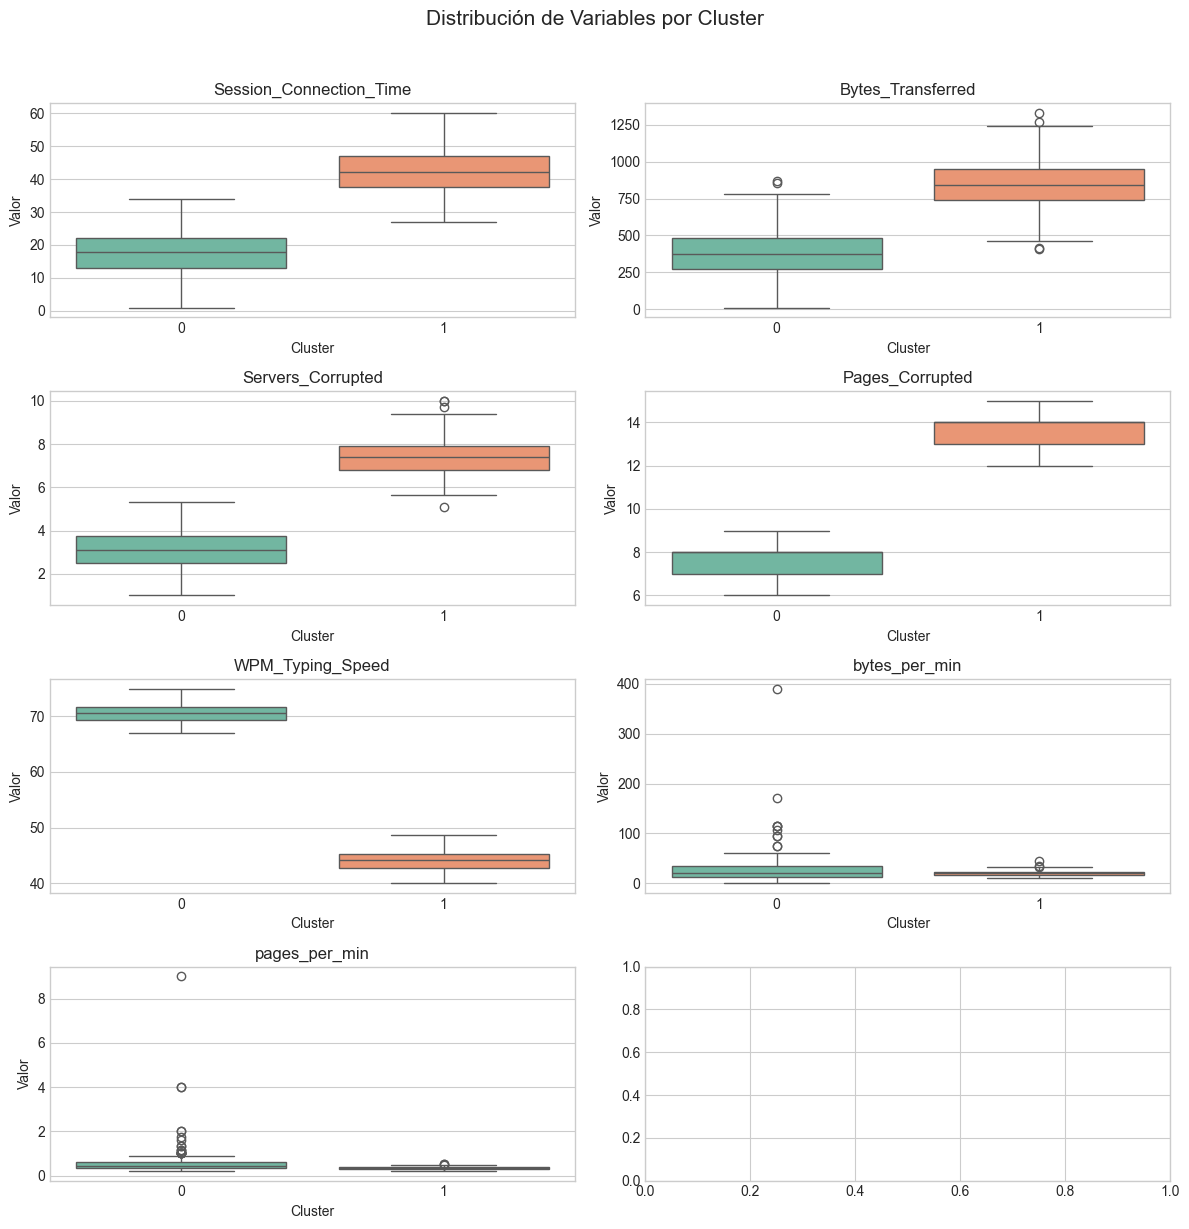

In [59]:
vars_show = [
    "Session_Connection_Time","Bytes_Transferred",
    "Servers_Corrupted","Pages_Corrupted","WPM_Typing_Speed",
    "bytes_per_min","pages_per_min"
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(vars_show):
    sns.boxplot(data=pdf, x="cluster", y=col, palette="Set2", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel("Valor")

plt.suptitle("Distribución de Variables por Cluster", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

Los boxplots confirman C1 con totales y duración mayores pero WPM bajo, mientras C0 exhibe mayor intensidad por minuto (bytes/pages per min) con algunos outliers altos.

Se recorre vars_show para dibujar boxplots por cluster, comparando medianas/IQR y extremos en un layout uniforme que facilita contrastar perfiles.


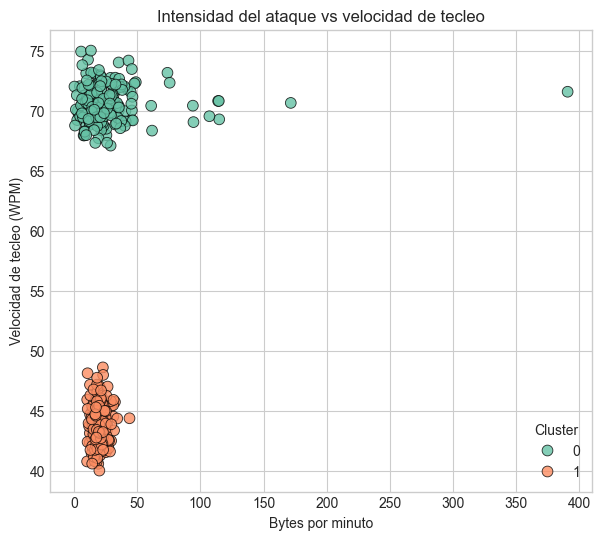

In [60]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pdf,
    x="bytes_per_min",
    y="WPM_Typing_Speed",
    hue="cluster",
    palette="Set2",
    s=60,
    alpha=0.8,
    edgecolor="k"
)
plt.title("Intensidad del ataque vs velocidad de tecleo")
plt.xlabel("Bytes por minuto")
plt.ylabel("Velocidad de tecleo (WPM)")
plt.legend(title="Cluster")
plt.show()


El scatter muestra dos nubes separadas: C0 con WPM alto y mayor dispersión de bytes/min (incluye outliers), y C1 con WPM bajo y baja intensidad por minuto.
Se grafican bytes_per_min vs WPM_Typing_Speed coloreando por cluster para evidenciar visualmente el eje discriminante “intensidad ↔ velocidad de tecleo”


In [ ]:
pdf_export = pdf.copy()
pdf_export['cluster'] = pdf_export['cluster'].astype(str)

pdf_export.to_csv('data/hack_data_clustered.csv', index=False)

print("Data exported successfully!")
print(f"Columns: {list(pdf_export.columns)}")
print(f"Shape: {pdf_export.shape}")

Data exported successfully!
Columns: ['Session_Connection_Time', 'Bytes_Transferred', 'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed', 'bytes_per_min', 'pages_per_min', 'servers_per_min', 'cluster', 'Location']
Shape: (334, 10)


Se exporta el dataset final con 334 filas y 10 columnas (incluye razones y cluster como string), quedando listo para el dashboard sin pasos extra.
Se copia pdf, tipa cluster a texto para filtros en UI y se guarda a data/hack_data_clustered.csv, imprimiendo columnas y shape como verificación rápida.


In [70]:
geo_counts = geo_df.groupby(['Location', 'cluster']).size().reset_index(name='count')

fig_geo = px.choropleth(
    geo_counts,
    locations="Location",
    locationmode="country names",
    color="count",
    facet_col="cluster",
    title="Attack Intensity by Location and Cluster",
    color_continuous_scale="Reds"
)
fig_geo.update_layout(
    geo=dict(showframe=False, showcoastlines=True, coastlinecolor="gray", landcolor="lightgray"),
)
fig_geo.show()


El mapa muestra ubicaciones muy dispersas y conteos bajos en ambos clusters, por lo que la geografía no explica la segmentación—la separación proviene del comportamiento (intensidad/WPM).
Se agrupa por Location y cluster para contar sesiones y se usa un choropleth facetado (Plotly) que permite comparar, de un vistazo, la distribución geográfica relativa de cada cluster.
